# LOAD LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
from datetime import datetime
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV, PredefinedSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# CONFIGURATION

In [9]:
START_DATE, END_DATE = '2022-09-01', '2023-10-05'
TIME_RESOLUTION = '4'
TARGET_FLUX = 'n2o'
QUALITY_FLAG = 'qcf0'
N_FOLDS = 10
MODEL_TYPE = 'XGBoost'  # Options: 'RandomForest' or 'XGBoost'
CROSSVAL_SPLIT = 'time_blocks_eliza' # options: 'shuffle' or 'kfold' or 'time_blocks_eliza'
LOG_TRANSFORM = True
ADD_ID = False
UNDERSAMPLE = True

# LOAD DATA

In [ ]:
data_main = pd.read_csv(f'../data/processed/DRIVERS_dataset_{TIME_RESOLUTION}h.csv', low_memory=False)
data_main['timestamp_middle'] = pd.to_datetime(data_main['timestamp_middle'])
data_main.set_index('timestamp_middle', inplace=True)
data_main = data_main.loc[START_DATE:END_DATE]

# Add an id column to account for the proximity of values as the timestamp is continuous without gaps
if ADD_ID:
    data_main['id'] = range(0, len(data_main))

# CLEAN DATA

In [4]:
TARGET = f'flux_{TARGET_FLUX}_{QUALITY_FLAG}'

# Remove NAs
data_main = data_main[data_main[TARGET].notna()]

# Remove any flux variable with target flux except for the target itself
to_drop = [col for col in data_main.columns if TARGET_FLUX in col]
# Leave the target!
to_drop.remove(TARGET)
data_main.drop(columns=to_drop, inplace=True)

data_main

,flux_nee_qcf_f_mds,flux_n2o_qcf0,flux_ch4_qcf_f_rf,flux_le_qcf_f_mds,flux_h_qcf_f_mds,flux_reco,flux_gpp,sw_in_pot,pa,prec,...,wfps_0.05_diff48h,wfps_0.15_diff12h,wfps_0.15_diff24h,wfps_0.15_diff48h,wfps_0.3_diff12h,wfps_0.3_diff24h,wfps_0.3_diff48h,wfps_0.5_diff12h,wfps_0.5_diff24h,wfps_0.5_diff48h
timestamp_middle,,,,,,,,,,,,,,,,,,,,,
2022-09-01 04:00:00,2.401638,0.242429,2.043430,6.856706,-4.799923,5.479219,3.077580,166.711538,96363.523167,0.0,...,1.704769,-0.303753,-0.094928,-0.469126,-0.077292,0.166907,-0.231051,-0.066340,-0.506643,-0.905881
2022-09-01 08:00:00,-12.171185,-0.020742,-2.530666,88.157572,62.396847,6.235522,18.406707,866.083500,96426.076583,0.0,...,2.387247,-0.499575,-0.485645,-0.278392,-0.165390,0.181054,-0.259238,-0.052891,-0.653769,-0.534071
2022-09-01 12:00:00,-10.763956,-0.233794,-0.585171,193.021731,95.585314,7.240746,18.004702,922.577125,96336.938208,0.0,...,-0.683744,-0.561318,-0.651114,-0.275279,-0.225380,-0.100895,-0.249998,-0.149358,-0.356730,-0.395967
2022-09-01 16:00:00,3.057288,-0.255840,-0.746813,17.152634,-5.299666,6.551054,3.493765,241.690413,96258.117667,0.0,...,-0.501322,-0.363214,-0.666967,-0.348724,-0.147678,-0.224971,-0.271450,-0.253301,-0.319641,-0.494004
2022-09-02 08:00:00,-14.678085,-0.265809,-5.932829,189.757780,138.704429,6.985861,21.663946,860.976250,96128.986667,0.0,...,-0.636248,-0.657767,-0.833842,-1.319487,-0.195572,-0.264905,-0.083852,-0.043227,-0.291053,-0.944822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-03 20:00:00,3.640106,0.904912,2.386634,4.501773,-29.475935,5.031657,1.391552,0.000000,97394.404250,0.0,...,-2.364172,-0.163795,-0.529972,-0.915471,-0.127161,-0.317963,-0.554744,-0.120864,-0.144342,-0.216338
2023-10-04 08:00:00,3.943206,0.781407,-6.808914,94.529160,153.159578,5.475166,1.531960,666.801250,97436.280458,0.0,...,-2.417786,-0.465864,-0.629659,-0.944960,-0.163389,-0.290550,-0.505746,-0.014372,-0.135236,-0.212566
2023-10-04 12:00:00,4.388155,1.360674,-0.815610,60.784127,75.674845,5.667781,1.279627,724.836375,97296.514750,0.0,...,-2.506386,-0.356637,-0.569158,-1.025921,-0.269625,-0.314303,-0.559491,-0.000076,-0.140468,-0.220404


# SELECT FEATURES

In [ ]:
# Import the best features
# path = '../data/processed/best_features_' + TARGET_FLUX + '_' + MODEL_TYPE + '_' + TIME_RESOLUTION + 'h.txt'
# with open(path, 'r') as f:
#     selected_features = [line.strip() for line in f]

# Other option is to define the best n features
# n_top = 20
# path = '../data/processed/ranked_features_' + TARGET_FLUX + '_' + MODEL_TYPE + '_' + TIME_RESOLUTION + 'h.txt'
# with open(path, 'r') as f:
#     selected_features = [line.strip() for line in f][:n_top]

# Selection based on 'ranked_features' and picking the most important features from each of the driver categories
selected_features = [
'n_decay_timed',
'timesince_fert', 
'timesince_soil_preparation',
'wfps_0.3_roll48hmean',
'wfps_0.3_diff48h',
'ts_0.3_roll48hmean',
'flux_gpp_roll48hsum'
]


# Keep only the best feature set
data = data_main[selected_features + [TARGET]].copy()

data

,n_decay_timed,timesince_fert,timesince_soil_preparation,wfps_0.3_roll48hmean,wfps_0.3_diff48h,ts_0.3_roll48hmean,flux_gpp_roll48hsum,flux_n2o_qcf0
timestamp_middle,,,,,,,,
2022-09-01 04:00:00,0.0,30,30,31.006986,-0.231051,19.504965,72.318492,0.242429
2022-09-01 08:00:00,0.0,30,30,30.985383,-0.259238,19.468605,71.271602,-0.020742
2022-09-01 12:00:00,0.0,30,30,30.964550,-0.249998,19.420058,77.264540,-0.233794
2022-09-01 16:00:00,0.0,30,30,30.941929,-0.271450,19.353177,80.504853,-0.255840
2022-09-02 08:00:00,0.0,30,30,30.936376,-0.083852,18.991678,94.061389,-0.265809
...,...,...,...,...,...,...,...,...
2023-10-03 20:00:00,0.0,30,7,53.457668,-0.554744,15.991667,12.512343,0.904912
2023-10-04 08:00:00,0.0,30,7,53.330581,-0.505746,16.009387,9.217772,0.781407
2023-10-04 12:00:00,0.0,30,7,53.283957,-0.559491,16.016933,7.554424,1.360674


# IMBALANCE HANDLING

## UNDER SAMPLING

Undersampling target data below: 1.0789741386666667


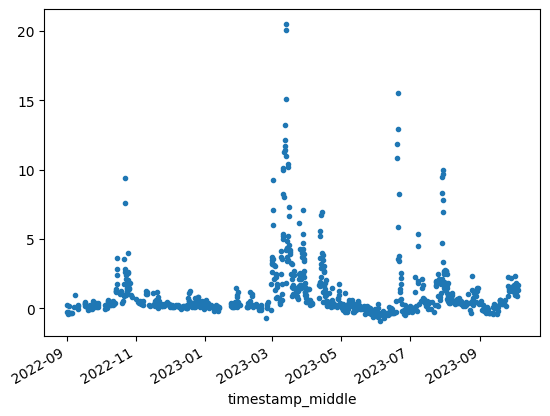

In [6]:
if UNDERSAMPLE:
    quantile_cutoff = 0.8
    cutoff_value = data[TARGET].quantile(quantile_cutoff)
    print(f'Undersampling target data below: {cutoff_value}')
    # Split and undersample
    upper = data[data[TARGET] > cutoff_value]
    lower = data[data[TARGET] <= cutoff_value]
    # Undersample
    lower_sampled = lower.sample(frac=0.5, random_state=42)
    # Combine
    data = pd.concat([upper, lower_sampled]).sample(frac=1, random_state=42)
    # Resort data
    data = data.sort_index().reset_index(drop=False)  # keep the timestamp as a column
    data = data.set_index('timestamp_middle')    # and set it back as index if needed
    # Plot
    data[TARGET].plot(x_compat=True, style='.');

## LOG TRANSFORMATION

The target was log transformed


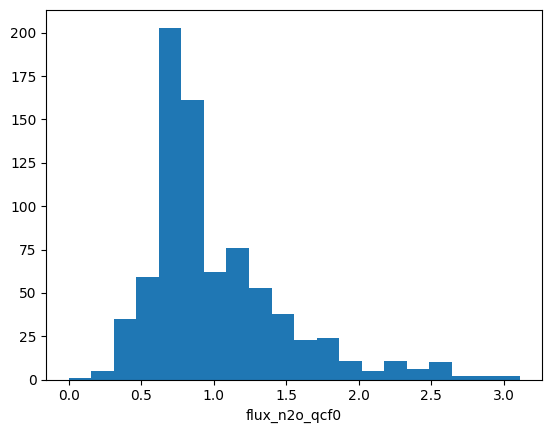

,n_decay_timed,timesince_fert,timesince_soil_preparation,wfps_0.3_roll48hmean,wfps_0.3_diff48h,ts_0.3_roll48hmean,flux_gpp_roll48hsum,flux_n2o_qcf0
timestamp_middle,,,,,,,,
2022-09-01 04:00:00,0.0,30,30,31.006986,-0.231051,19.504965,72.318492,0.756479
2022-09-01 12:00:00,0.0,30,30,30.964550,-0.249998,19.420058,77.264540,0.503521
2022-09-01 16:00:00,0.0,30,30,30.941929,-0.271450,19.353177,80.504853,0.490107
2022-09-02 12:00:00,0.0,30,30,30.906030,-0.364155,18.888952,90.494931,0.374641
2022-09-03 08:00:00,0.0,30,30,30.710465,-0.544465,18.565416,89.116953,0.721050
...,...,...,...,...,...,...,...,...
2023-10-03 12:00:00,0.0,30,6,53.547226,-0.551847,15.994288,13.880937,1.278283
2023-10-03 16:00:00,0.0,30,7,53.503897,-0.519952,15.993241,11.711440,1.204291
2023-10-03 20:00:00,0.0,30,7,53.457668,-0.554744,15.991667,12.512343,1.027203


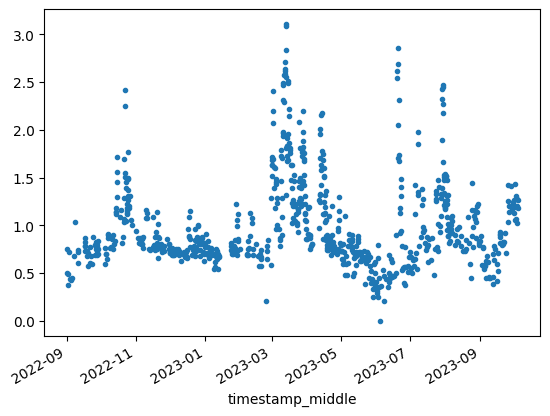

In [ ]:
min_value = data[TARGET].min()

def log_transform(x):
    return np.log1p(x - min_value) if min_value < 0 else np.log1p(x)

def inverse_log_transform(x):
    return np.expm1(x) + min_value if min_value < 0 else np.expm1(x)

if LOG_TRANSFORM:
    data[TARGET] = log_transform(data[TARGET])
    print('The target was log transformed')
    # Show histogram of TARGET
    plt.hist(data[TARGET], bins=20)
    plt.xlabel(TARGET)
    plt.show()
    # Show timeseries
    data[TARGET].plot(x_compat=True, style='.');

# CROSS-VAL SPLITS

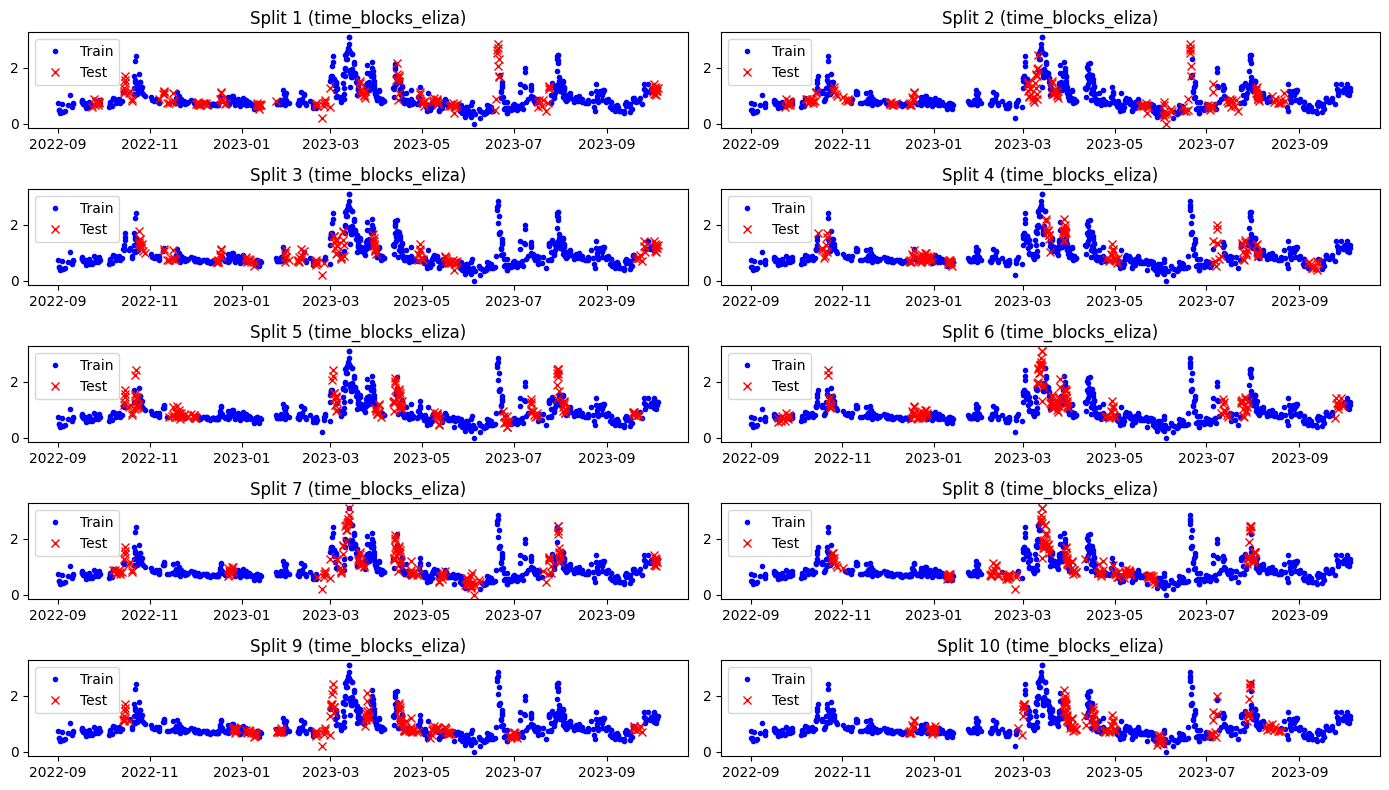

In [10]:
def create_splits(X, y, n_folds, test_size=0.2, random_state=42, n_bins=5):
    """Creates train-test splits using StratifiedShuffleSplit or StratifiedKFold with equal-width binning."""
    
    # Use pd.cut to create equal-width bins (avoids empty bins issue)
    y_binned = pd.cut(y, bins=n_bins, labels=False, include_lowest=True)

    # Select method for stratified splitting
    if CROSSVAL_SPLIT == "shuffle":
        splitter = StratifiedShuffleSplit(n_splits=n_folds, test_size=test_size, random_state=random_state)
    elif CROSSVAL_SPLIT == "kfold":
        splitter = StratifiedKFold(n_splits=n_folds, shuffle=False)

    # Generate train-test splits
    splits = [(train_idx, test_idx) for train_idx, test_idx in splitter.split(X, y_binned)]

    return splits

if CROSSVAL_SPLIT == 'time_blocks_eliza':
    def create_splits(X, y, n_folds, split=0.2, mean_block = 10, min_block=5, random_state=42): # you can set mean block to median_nan_size
        """Generates multiple train-test index splits using block-based cross-validation by varying the random seed."""
        splits = []
        total_test = round(len(X) * split)
        n_blocks = round(total_test/mean_block)

        if mean_block < min_block:
            raise ValueError("Min block size is too large for the number of blocks.")

        for fold in range(n_folds):
            np.random.seed(random_state + fold)  # Change seed for each fold
            
            tt = np.zeros(len(X))  # Array to store train-test assignments

            # Generate random block sizes with normal variation
            blocks = np.array([max(min_block, mean_block + round(v)) 
                            for v in np.random.normal(0, mean_block / 10, n_blocks)])

            # Randomly shuffle the starting positions of test blocks
            available_positions = np.arange(len(X))  # Possible start positions
            np.random.shuffle(available_positions)   # Shuffle them

            # Assign blocks sequentially based on shuffled positions
            assigned = set()
            for b in blocks:
                if len(assigned) >= total_test:
                    break
                # Pick a random starting position
                istart = np.random.choice(available_positions)
                iend = min(istart + int(b), len(X))

                # Ensure blocks don't overlap significantly
                assigned.update(range(istart, iend))
                tt[istart:iend] = 1

            train_idx = np.where(tt == 0)[0]
            test_idx = np.where(tt == 1)[0]
            
            splits.append((train_idx, test_idx))

        return splits

X = data.drop(columns=TARGET)
y = data[TARGET]
# Create the splits using StratifiedShuffleSplit
cross_val_splits = create_splits(X, y, n_folds=N_FOLDS)


# --- PLOT TRAIN-TEST SPLITS ---
n_rows = math.ceil(N_FOLDS / 2)  # Ensure enough rows for all splits
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 8))
axes = axes.flatten()  # Flatten the axes array to make iteration easier

for i, (train_idx, test_idx) in enumerate(cross_val_splits):
    train_idx_mapped = X.iloc[train_idx].index
    test_idx_mapped = X.iloc[test_idx].index

    # Plot train and test points
    axes[i].plot(y.loc[train_idx_mapped].index, y.loc[train_idx_mapped], '.', label='Train', color="blue")
    axes[i].plot(y.loc[test_idx_mapped].index, y.loc[test_idx_mapped], 'x', label='Test', color="red")
    
    axes[i].set_title(f"Split {i + 1} ({CROSSVAL_SPLIT})")
    axes[i].legend()

# Hide unused subplots if n_folds is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# HYPERPARAMETER TUNING

In [11]:
# Convert cross-val splits into PredefinedSplit format to be able to use them in GridSearchCV
test_fold = np.full(len(data), -1)  # Initialize with -1 (all as training)
for fold_idx, (train_idx, test_idx) in enumerate(cross_val_splits):
    test_fold[test_idx] = fold_idx  # Assign test samples to a specific fold
predefined_cv = PredefinedSplit(test_fold)

param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100, 300, 500], # Similar to XGBoost
        'max_depth': [3, 5, 10, 15], # Controls tree depth
        'min_samples_split': [2, 5, 10], # Similar to min_child_weight
        'min_samples_leaf': [1, 3, 5], # Controls leaf size
        'max_features': [0.4, 0.6, 0.8, 1.0], # Similar to colsample_bytree
    },
    'XGBoost': {
        'n_estimators': [50, 100, 300, 500],
        'gamma': [0, 0.2, 0.4],
        'max_depth': [3, 5, 10, 15],
        'learning_rate': [0.001, 0.005, 0.01, 0.05],
        'subsample': [0.65, 0.75, 1],
        'colsample_bytree': [0.4, 0.6, 0.8, 1],
        'min_child_weight': [2, 5, 10]
    }
}

model_class = RandomForestRegressor if MODEL_TYPE == 'RandomForest' else XGBRegressor
param_grid = param_grids[MODEL_TYPE]
model = model_class(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=predefined_cv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(data[selected_features], data[TARGET])

print("Best Parameters:", grid_search.best_params_)

KeyboardInterrupt: 

# EXPORT 

In [ ]:
filename = '../data/processed/best_hyperparameters_' + TARGET_FLUX + '_' + MODEL_TYPE + '_' + TIME_RESOLUTION + 'h.json'
with open(filename, "w") as f:
    json.dump(grid_search.best_params_, f)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

# **End of notebook**

In [13]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2025-12-12 16:45:45
